In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_compression as tfc
import matplotlib.pyplot as plt

import os
import h5py

from BalleFFP_improved import BalleFFP
from read_data import read_data_numpy

2023-03-08 11:23:05.230317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 11:23:05.389771: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-08 11:23:05.979389: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ubuntu/data/miniconda3/envs/tf2/lib/
2023-03-08 11:23:05.979486: W tensorflow/co

## General Settings

In [2]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [3]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 14

In [4]:
tf.config.set_visible_devices([], 'GPU')

2023-03-08 11:23:08.811718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 11:23:08.812924: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 11:23:08.825117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 11:23:08.826614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 11:23:08.828229: I tensorflow/compiler/xla/stream_executo

## Functions

In [5]:
def get_model_files(folder, name):
    files  = os.listdir(folder)
    files  = [f for f in files if name in f]
    models = [f for f in files if "model" in f]
    losses = [f for f in files if "losses" in f]
    return models, losses

In [6]:

def show_image_comparison(img, reco, id, format):
    """Visualize the original image and the reconstructed image side by side."""
    if format=='channels_first':
        img  = np.transpose(img, (1, 2, 0))
        reco = np.transpose(reco, (1, 2, 0))
    
    # check if the images are normalized
    norm_img  = np.max(img)  <= 1.0
    norm_reco = np.max(reco) <= 1.0

    # Create a 4x4 grid of images
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), constrained_layout=True)
    axes[0].imshow(img  if norm_img  else img.astype(np.uint8)) 
    axes[1].imshow(reco if norm_reco else reco.astype(np.uint8)) 
    
    axes[0].axis('off')
    axes[1].axis('off')
    
    fig.suptitle('Original image (left) and reconstructed image (right) (id: {})'.format(id))

    # Show the plot
    plt.show()

def show_image_comparison_bitrate(img, reco, id, format, compressor):
    """Visualize the original image and the reconstructed image side by side."""
    if format=='channels_first':
        img  = np.transpose(img, (1, 2, 0))
        reco = np.transpose(reco, (1, 2, 0))
    
    # check if the images are normalized
    norm_img  = np.max(img)  <= 1.0
    norm_reco = np.max(reco) <= 1.0

    bits_img     = np.product(img.shape)*8
    _, bits_reco = compressor(np.expand_dims(img, 0))

    print('Bitrate shape:', bits_reco.shape)

    # Create a 4x4 grid of images
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), constrained_layout=True)
    axes[0].imshow(img  if norm_img  else img.astype(np.uint8)) 
    axes[1].imshow(reco if norm_reco else reco.astype(np.uint8)) 
    
    axes[0].axis('off')
    axes[1].axis('off')

    axes[0].set_title(f'{bits_img} bits')
    axes[1].set_title(f'{tf.reduce_sum(bits_reco):.2f} bits')
    
    fig.suptitle('Original image (left) and reconstructed image (right) (id: {})'.format(id))

    # Show the plot
    plt.show()

In [7]:
def select_random_images(data, n):
    """Selects n random images from the data."""
    idx = np.random.choice(data.shape[0], n, replace=False)
    return data[idx], idx

In [8]:
class Compressor(tf.keras.Model):

    def __init__(self, model, cr):

        super(Compressor, self).__init__()

        self.encoder = model.encoder
        self.prior   = model.prior
        self.bemodel = tfc.ContinuousBatchedEntropyModel(
            prior = self.prior,
            coding_rank=cr,
            compression=True
        )

    def call(self, inputs):

        encoded = self.encoder(inputs, training=False)

        _, bits   = self.bemodel(encoded, training=False)
        bitstring = self.bemodel.compress(encoded)

        return bitstring, bits

## Constants

In [9]:
DATA_FOLDER  = "../data/stl10/stl10_binary/"
DATA_FILE    = "unlabeled_X.bin"

CH_FORMAT = "channels_last"
EPOCHS    = 50
NORM      = False
LAMBDA    = "0.01"
COD_RANK  = 1

MODEL_FOLDER = "../models/"

## Load Data

In [10]:
data_path = os.path.join(DATA_FOLDER, DATA_FILE)
data      = read_data_numpy(data_path, CH_FORMAT).astype('float32') 

if NORM == "normTrue":
    # normalize the data to [0,1]
    data = data / 255.0

## Choose the trained model

In [11]:
name = "ffp_{}_epochs{}_norm{}_l{}_cr{}".format(CH_FORMAT, EPOCHS, NORM, LAMBDA, COD_RANK)

models, losses = get_model_files(MODEL_FOLDER, name)
print("Models: ", models)


Models:  ['model_ffp_channels_last_epochs50_normFalse_l0.01_cr1_20230307041231.h5', 'model_ffp_channels_last_epochs50_normFalse_l0.01_cr1_20230308075239.h5']


In [12]:
model_path = os.path.join(MODEL_FOLDER, models[0])
loss_path  = os.path.join(MODEL_FOLDER, losses[0])

print("Loading model from: ", model_path)

Loading model from:  ../models/model_ffp_channels_last_epochs50_normFalse_l0.01_cr1_20230307041231.h5


## Train/Test loss

In [13]:
# open the .h5 file containing the losses and load them as two numpy arrays train_loss and test_loss
with h5py.File(loss_path, 'r') as f: # type: ignore
    train_loss = np.array(f['train'])
    test_loss  = np.array(f['test'])

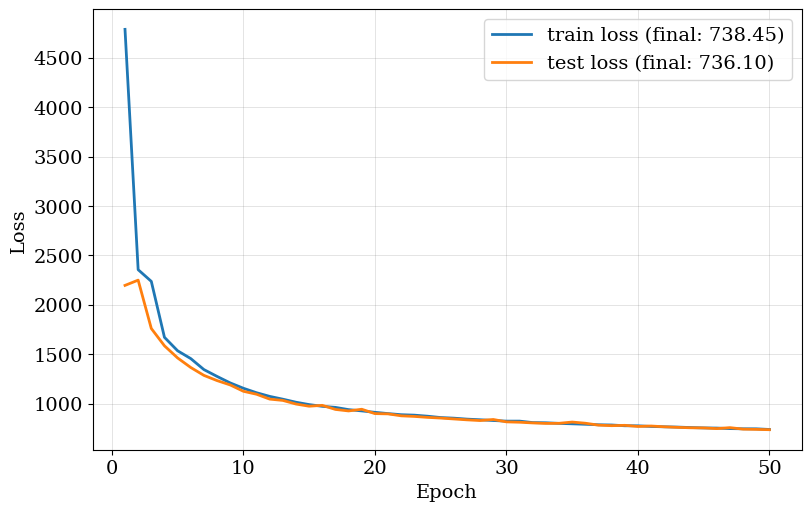

In [14]:
epochs = np.arange(1, len(train_loss)+1)


fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
ax.grid(True, which='both', ls='-', lw=0.5, c='grey', alpha=0.3)

ax.plot(epochs, train_loss, lw=2, label=f"train loss (final: {train_loss[-1]:.2f})")
ax.plot(epochs, test_loss,  lw=2, label=f"test loss (final: {test_loss[-1]:.2f})")

ax.legend()

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# fig.savefig("./plots/losses.png", dpi=300, facecolor="w")

plt.show()

## Image Reconstruction

In [15]:
vae = BalleFFP(N=128, M=192, k2=3, c=3, format=CH_FORMAT)

if CH_FORMAT == 'channels_first':
    x = tf.zeros((1, 3, 96, 96))
    
elif CH_FORMAT == 'channels_last':
    x = tf.zeros((1, 96, 96, 3))
else:
    raise ValueError("CH_FORMAT must be either 'channels_first' or 'channels_last'")

# call the model to create the weights
_ = vae(x)

# load the weights from the .h5 file
vae.load_weights(model_path)

2023-03-08 11:24:28.540208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
img, ids = select_random_images(data, 4)

img_reco, rate_reco = vae(img) # type: ignore

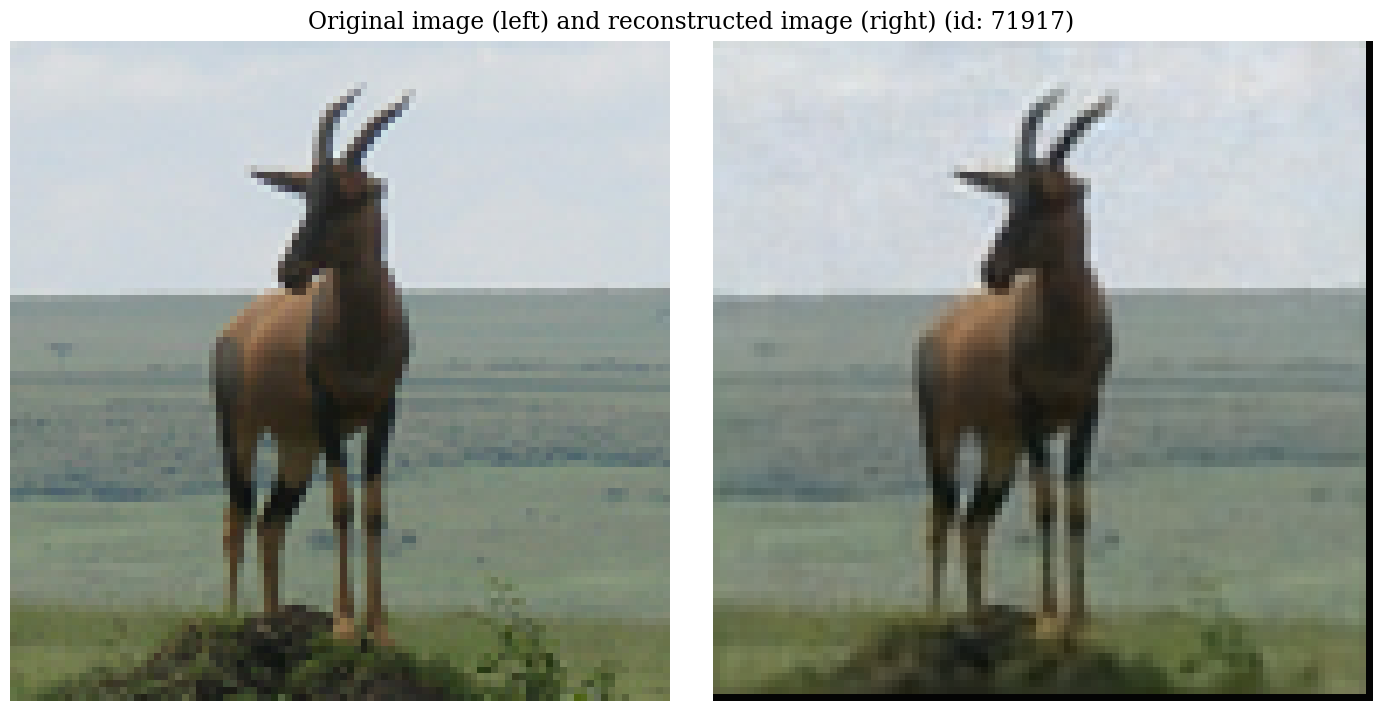

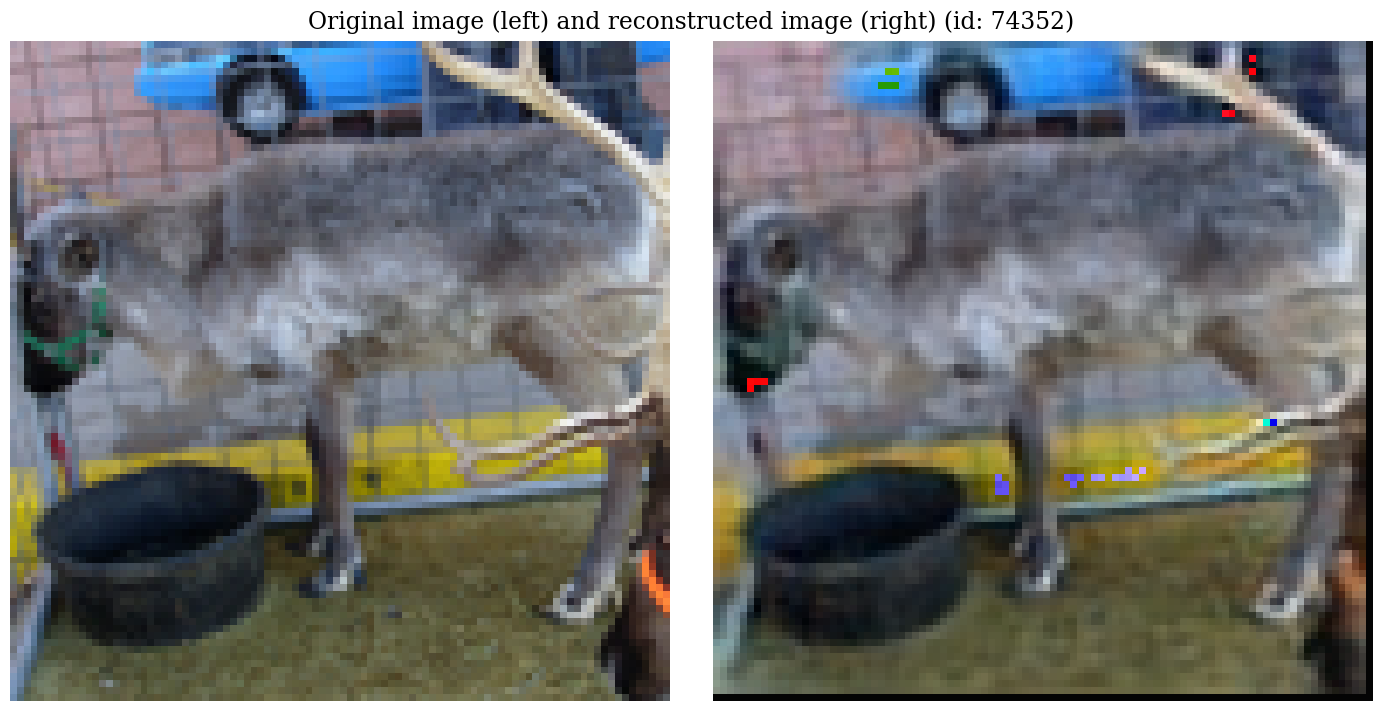

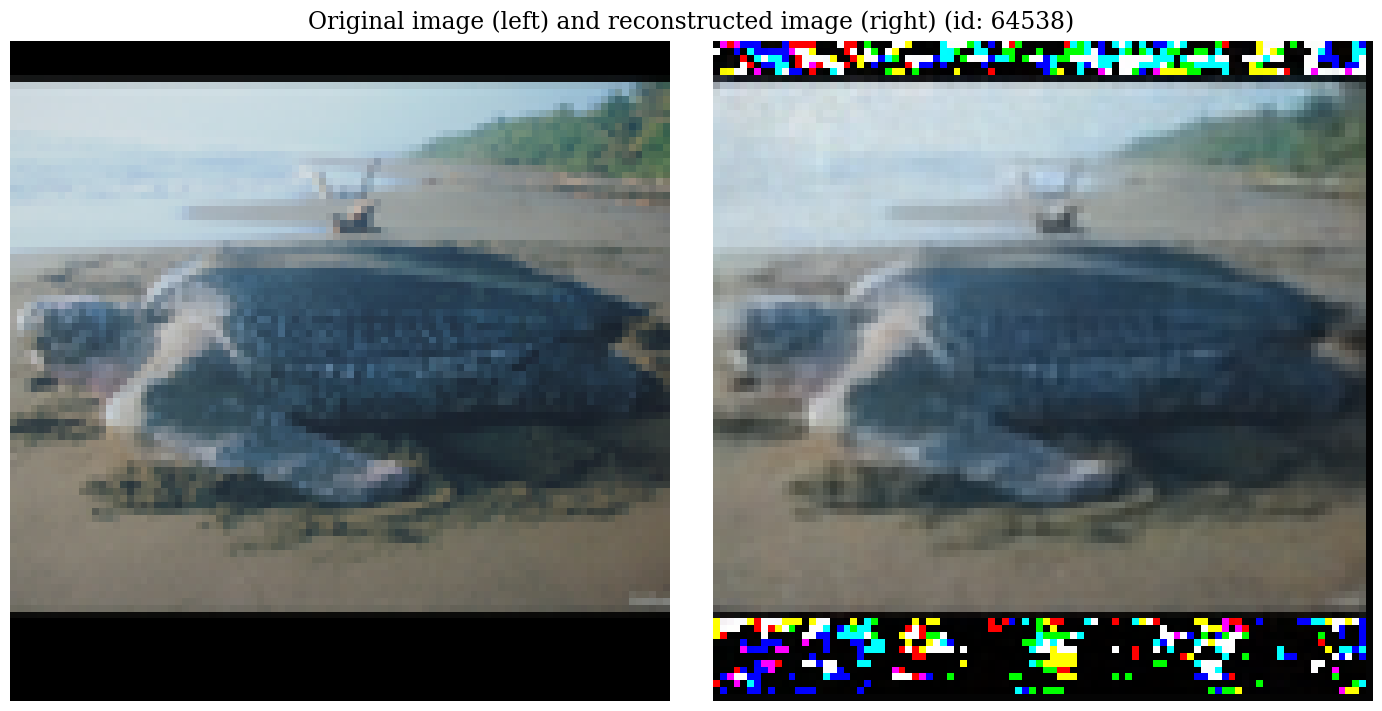

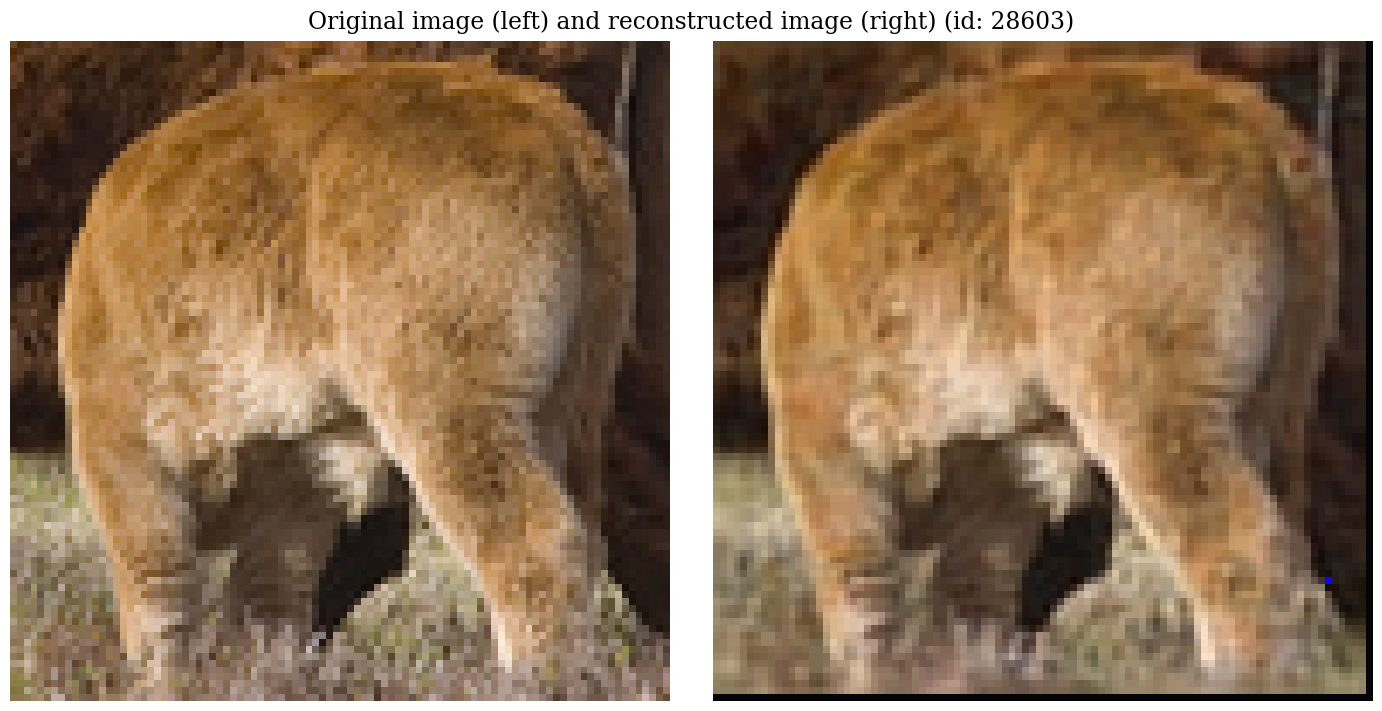

In [18]:
for i in range(img.shape[0]):
    show_image_comparison(img[i], img_reco[i], ids[i], CH_FORMAT)

## Bitrate

In [17]:
compressor = Compressor(vae, COD_RANK)

Bitrate shape: (1, 9, 9)


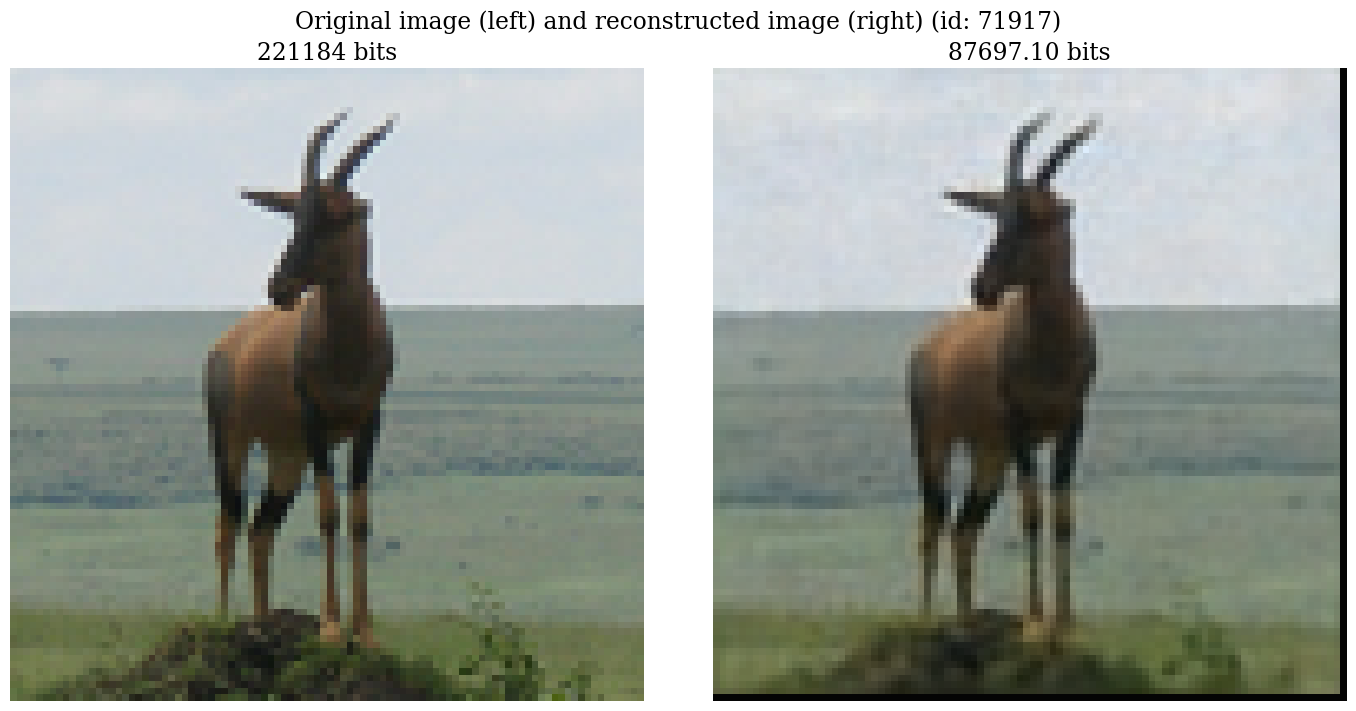

Bitrate shape: (1, 9, 9)


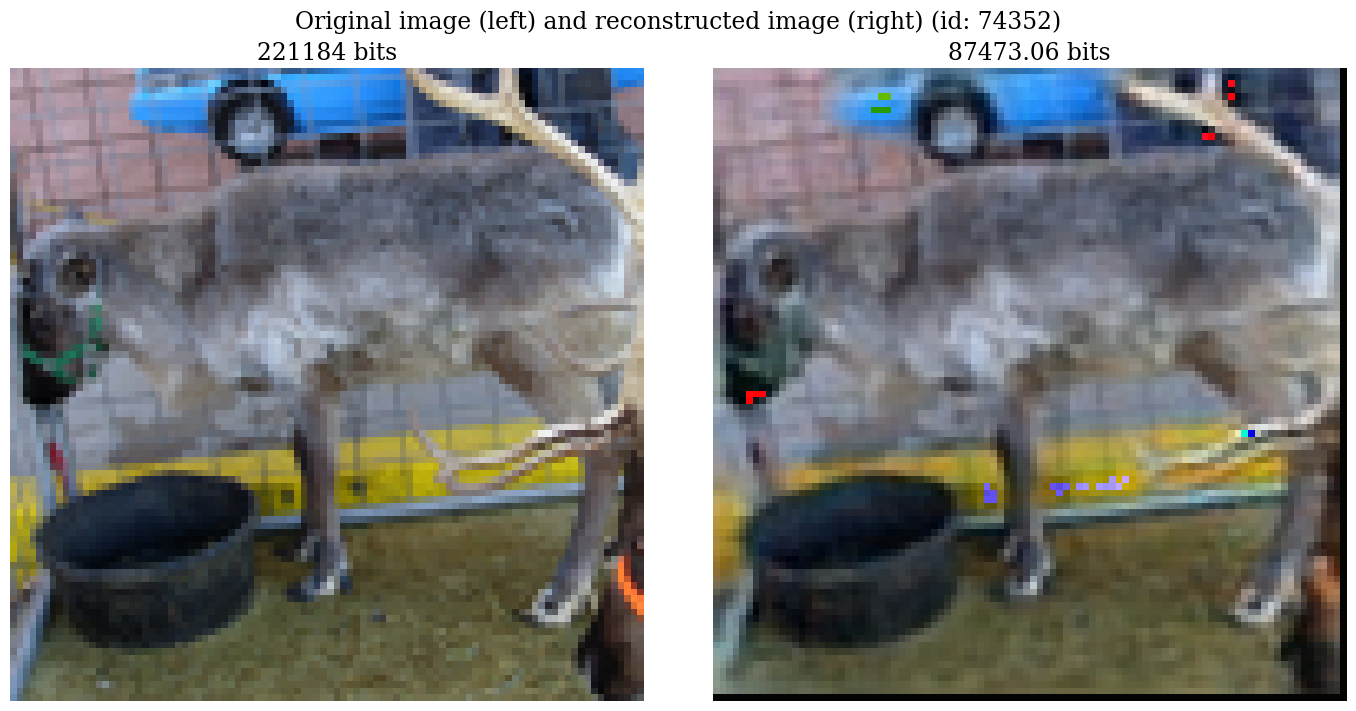

Bitrate shape: (1, 9, 9)


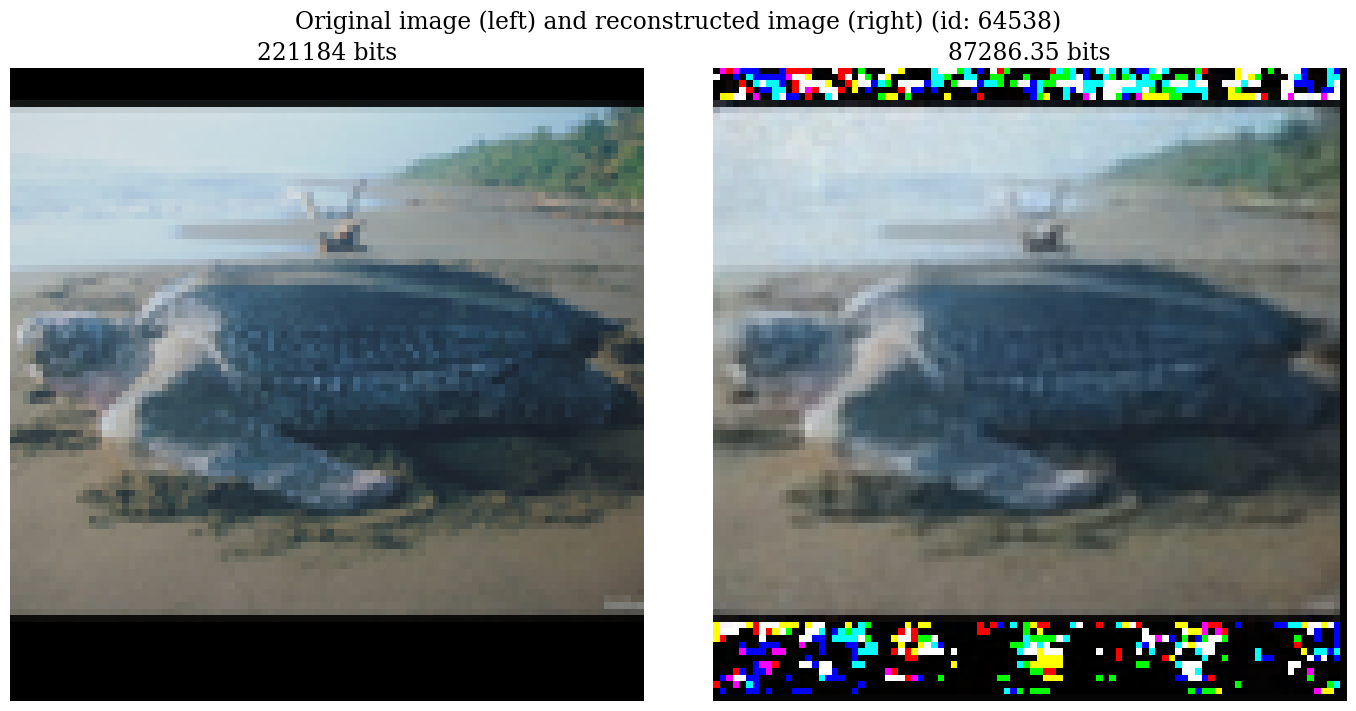

Bitrate shape: (1, 9, 9)


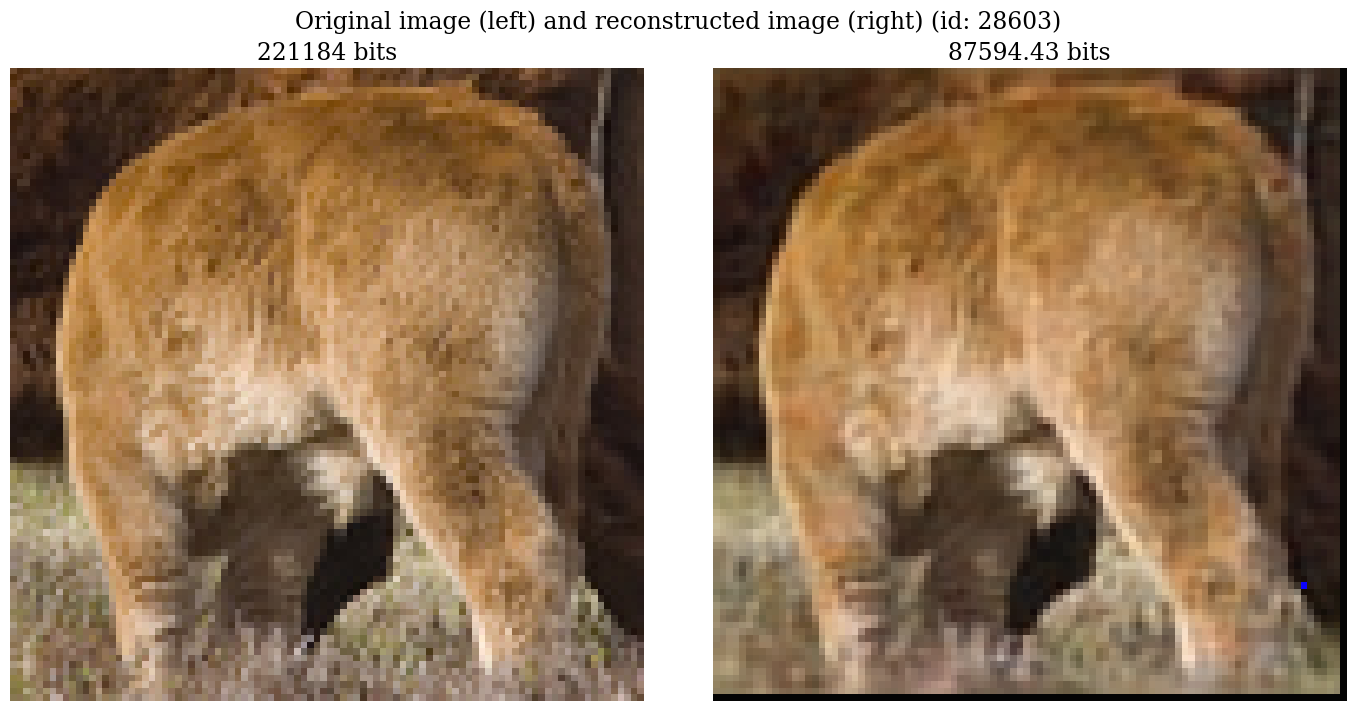

In [20]:
for i in range(img.shape[0]):
    show_image_comparison_bitrate(img[i], img_reco[i], ids[i], CH_FORMAT, compressor)

In [18]:
N = 1_000

data_1e3, idx = select_random_images(data, N)
data_1e3 = tf.constant(data_1e3)

img_reco, _ = vae(data_1e3, training=False)

## PSNR

In [60]:
def PSNR(data, normalized = False):

    """
    INPUTS: original image and its compressd version
    """
    mse = tf.reduce_mean((data[0] - data[1]) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 10000
    if normalized: 
        max_pixel = 1.0 # if is not normalize
    else: 
        max_pixel = 255.0

    psnr = 20 * tf.experimental.numpy.log10(max_pixel / tf.sqrt(mse)) #from definition
    return psnr

def psnr_onbatch(img, img_reco):

    if type(img) == np.ndarray:
        img = tf.constant(img)

    psnrs       = tf.map_fn(PSNR, (img, img_reco), dtype=(tf.float32, tf.float32), fn_output_signature=tf.float32)
    psnr_mean   = tf.reduce_mean(psnrs)
    psnr_var    = tf.math.reduce_variance(psnrs)

    return psnr_mean.numpy(), tf.sqrt(psnr_var).numpy()

In [62]:
psnr_onbatch(data_1e3, img_reco)

(23.456705, 2.869939)

## MS-SSIM

In [103]:
def msssim_onbatch(img, img_reco, ch_format, normalized=False):
    if ch_format == 'channels_first':
        img = img.transpose((0, 2, 3, 1))
    if type(img) == np.ndarray:
        img = tf.constant(img)

    msssim = tf.image.ssim_multiscale(img, img_reco, 1.0 if normalized else 255.0, filter_size=6)
    return tf.reduce_mean(msssim).numpy(), tf.sqrt(tf.math.reduce_variance(msssim)).numpy()

In [104]:
msssim_onbatch(data_1e3, img_reco, CH_FORMAT, NORM)

0.98093724

## Mutual Information

In [21]:
def mi_oe_onbatch(image1, image2):
    # Convert images to grayscale
    image1 = tf.reduce_mean(image1, axis=[1, 2, 3])
    image2 = tf.reduce_mean(image2, axis=[1, 2, 3])

    # Compute marginal histograms
    hist1, _ = np.histogram(image1, bins='auto')
    hist2, _ = np.histogram(image2, bins='auto')

    # Compute joint histogram
    joint_histogram, _, _ = np.histogram2d(image1, image2, bins=[hist1.shape[0], hist2.shape[0]])

    # Normalize joint histogram
    pxy = joint_histogram / np.sum(joint_histogram)


    # Normalize marginal histograms
    px = hist1 / np.sum(hist1)
    py = hist2 / np.sum(hist2)

    px_py = px[:, None] * py[None, :]

    # Compute mutual information

    nzrs_msk = pxy > 0

    return np.sum(pxy[nzrs_msk]*np.log2(pxy[nzrs_msk] / px_py[nzrs_msk]))


In [ ]:
def mi_eb_onbatch(images, bitstrings):
    # Convert images to grayscale
    image1 = tf.reduce_mean(images, axis=[1, 2, 3])
    image2 = tf.reduce_mean(bitstrings, axis=[1, 2, 3]) if len(bitstrings.shape)>1 else bitstrings

    # Compute marginal histograms
    hist1, _ = np.histogram(image1, bins='auto')
    hist2, _ = np.histogram(image2, bins='auto')

    # Compute joint histogram
    joint_histogram, _, _ = np.histogram2d(image1, image2, bins=[hist1.shape[0], hist2.shape[0]])

    # Normalize joint histogram
    pxy = joint_histogram / np.sum(joint_histogram)


    # Normalize marginal histograms
    px = hist1 / np.sum(hist1)
    py = hist2 / np.sum(hist2)

    px_py = px[:, None] * py[None, :]

    # Compute mutual information

    nzrs_msk = pxy > 0

    return np.sum(pxy[nzrs_msk]*np.log2(pxy[nzrs_msk] / px_py[nzrs_msk]))

In [22]:
mi_oe_onbatch(data_1e3, img_reco)

3.5928507312349613

In [45]:
bitstrings.reshape((1000, -1))

<tf.Tensor: shape=(1000, 81), dtype=string, numpy=
array([[b'x\xe3\xb1\x97C\xb4T\xf9?V\xad\x93\xe3\xe7\xda\xba\x98\t\xdf\xf7\xd2 \xaf\xd63\x91\xe10\xe9%\xe6L\x99j\xc8\xbbn~\x82o&\xf8l\x90~*B.\xa7\x89\xcf\rXdi*[\x8a_\xe21\x08\x9fU\xcd\xae\x9dR\x8dU\x9b\x89\x90\x85\xe0\xfa\x9el\xf1i\x0b\x9b\xa3\xac\xfa\n\xb5j\xee@\x04\xb0\xa1#\x16c\x99\x12Q\xfct\x90\x92\xcaL\x91\xd5H\x14y\x94\xe7\x9c.\x10\xf2J\xeb?\x10\x942=\xa2\xedC\x144\xba\xd4\xe6\xb6Kbrf\x12s\xc6\t',
        b'\xbb\xec\x86\xe5\xc6v\x81\xa1\x00\xa6)\xd6\x02\xcb\x1b\x8f\x06\x03\xc0\x86C\x9f\x1c\xecj?2\xa8\xf6mxQg\xbe\xfc\xf4\xe1\x1e\xc7%\xea\xa8\xb6\xcc\xcbck]1\xf0\xf95\xcd\xfe\x82\xc6\xee\xc3\x1e<\xc4\x03\x0eQ\xdda\xf0\xad2\xb9\xfc\x9a\x01\x03\xa9\xccO\xc2\xc1\xf2S\x11p\xbe\xd9\xc5<\xb1m\xa2\x15\xa0\xb7\xb2\xca\x12\xed\x0f\xfa\xc5\xac[\x05\x18\xe1I7\xc2\x0f \x96;e\xfb\xf4\xc28\xcd:)\x8c\xb7Z\xce\xb3c\xa3fb\x05J`*\x0f@\x0f\xfaH\xaf',
        b'\xbb*\x9eb\xcf\xdc\x90\xc9\xaepl\xc1\xce\x1a\xc7\x1a\x04\x8b\xce\x96u\xe7\x9f|\xe04\xe1T\x9b\

In [50]:
bitstrings, _ = compressor(img_reco)

bitstrings_int = tf.map_fn(lambda x: int(x.numpy().hex(), 16), bitstrings.reshape((-1)))

StagingError: in user code:

    File "/tmp/ipykernel_511662/1287908224.py", line 3, in None  *
        lambda x: int(x.numpy().hex(), 16)/int(1e15)

    OverflowError: integer division result too large for a float


In [43]:
tf.reduce_mean(bitstrings, axis=[1, 2])

InvalidArgumentError: Value for attr 'T' of string is not in the list of allowed values: float, double, int32, uint8, int16, int8, complex64, int64, qint8, quint8, qint32, bfloat16, uint16, complex128, half, uint32, uint64
	; NodeDef: {{node Mean}}; Op<name=Mean; signature=input:T, reduction_indices:Tidx -> output:T; attr=keep_dims:bool,default=false; attr=T:type,allowed=[DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT16, 6034766930529145842, DT_UINT16, DT_COMPLEX128, DT_HALF, DT_UINT32, DT_UINT64]; attr=Tidx:type,default=DT_INT32,allowed=[DT_INT32, DT_INT64]> [Op:Mean]